# Generating npy files for Multi-Class Semantic Segmentation task

The main reason to generate npy files is to make our data loader simple and easy to handle. Though this step can also be included in your python file and include if else condition for the case of availability of npy files. Yet, here a seperate notebook was stored to provide easy understanding of the step included in the preprocessing steps.

In [1]:
# import necessary packages

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from skimage import exposure
from skimage import io

## necessary function

In [2]:
#function to plot
def visualize_data(image,label):
    f, axarr = plt.subplots(1,2)
    image = image[:, :, 0:3]
    _ = image[:, :, 0].copy()
    image[:, :, 0] = image[:, :, 2]
    image[:, :, 2] = _
    image = image.astype(np.float64)
    for i in range(image.shape[2]):
        p2, p98 = np.percentile(image[:, :, i], (2, 98))
        image[:, :, i] = exposure.rescale_intensity(image[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(image)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(label.ravel())
    im = axarr[1].imshow(label[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    label = ["No Dwellings","Blue Dwellings", "Bright Dwellings","Iron Roof Dwellings","Dark Dwellings","Dismantled Dwellings","Green Dwellings","Red Dwellings"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), label)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

In [10]:
PATCHSIZE = 256

def gridwise_sample(imgarray, patchsize):
    ''' to make a grid of 256x256 on top of the image and create sample patches '''
    nbands,nrows, ncols = imgarray.shape
    patchsamples = np.zeros(shape=(0, nbands,patchsize, patchsize),
                            dtype=imgarray.dtype)
    
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[:,i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

## load entire images or patches

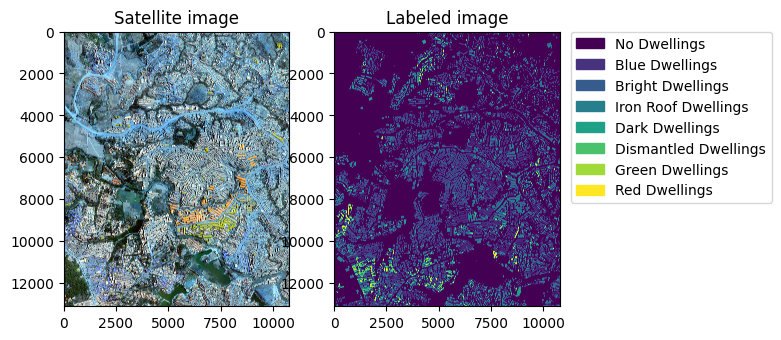

In [5]:
# used dataset
Image = rasterio.open("./image/Kutupalong_13Feb2018_sub.tif").read()
Label = rasterio.open("./label/Multiclass.tif").read()
visualize_data(np.swapaxes(Image,0,2), np.swapaxes(Label,0,2))

In [8]:
# checking max and min
print(f"max of img:{Image.max()}")
print(f"min of img:{Image.min()}")
print(f"max of lab:{Label.max()}")
print(f"min of lab:{Label.min()}")

max of img:255
min of img:0
max of lab:7
min of lab:0


### Image Patching

Instead of random patching, here we are creating patches from entire dataset as we lack enough dataset.

In [11]:
Xdata = gridwise_sample(Image, PATCHSIZE)
Ydata = gridwise_sample(Label, PATCHSIZE)
print(f"Shape of Xdata is {Xdata.shape}")
print(f"Shape of Ydata is {Ydata.shape}")

Shape of Xdata is (2142, 3, 256, 256)
Shape of Ydata is (2142, 1, 256, 256)


### Removing data with NAN values

In [12]:
# remove nan
img = []
lab = []
for i in range(len(Xdata)):
    a = Xdata[i,:,:,:]
    b = Ydata[i,:,:,:]
    if np.isnan(a.any()):
        np.delete(a)
        np.delete(b)
    elif np.isnan(b.any()):
        np.delete(a)
        np.delete(b)
    else:
        img.append(a)
        lab.append(b)
total_img = np.asarray(img)
total_lab = np.asarray(lab)
print(f"shape of image is{total_img.shape}")
print(f"shape of image is{total_lab.shape}")

shape of image is(2142, 3, 256, 256)
shape of image is(2142, 1, 256, 256)


### Augumentation if needed

In [13]:
#image augumentation
Xfliped = total_img[:,:,::-1, :]
Xmirrored = total_img[:,:,:,::-1]

#label augumentation
Yfliped = total_lab[:,:,::-1, :]
Ymirrored = total_lab[:,:,:,::-1]

#Lets append the datasets
Xfliped=np.append(total_img,Xfliped,axis=0)
Xtotal=np.append(Xfliped,Xmirrored,axis=0)
Yfliped=np.append(total_lab,Yfliped,axis=0)
Ytotal=np.append(Yfliped,Ymirrored,axis=0)

#print shapes
Xtotal.shape,Ytotal.shape

((6426, 3, 256, 256), (6426, 1, 256, 256))

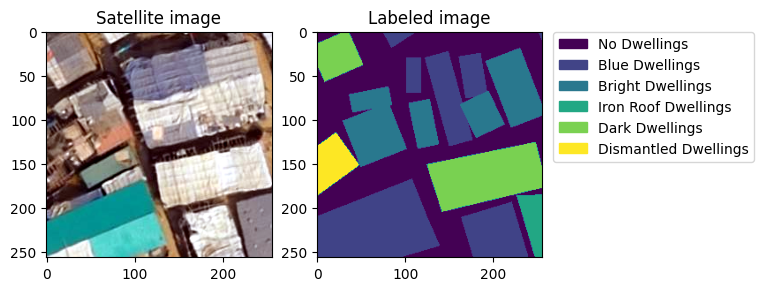

In [14]:
visualize_data(Xtotal[5800,:,:,:].swapaxes(0,2),Ytotal[5800,:,:,:].swapaxes(0,2)) #Visualize Images Side by Side

### saving and loading as npy only after preprocessing

Here, since I am performing one hot encoding on the already prepared npy file in my python files so I am showing the saving steps prior to one-hot encoding. Thus, one hot encoding can be done either directly or npy files or do it befor preparing npy files as per your wish.

In [2]:
# np.save('MultiClassSegmentation/dataloader/npy/Xdata_256mul_nonorm.npy', Xtotal) # save
# np.save('MultiClassSegmentation/dataloader/npy/Ydata_256mul_nonorm.npy', Ytotal) # save

# loading in case needed
Xmain = np.load('/home/jovyan/private/MultiClassSegmentation/dataloader/npy/Xdata_256mul_nonorm.npy')
Ymain = np.load('/home/jovyan/private/MultiClassSegmentation/dataloader/npy/Ydata_256mul_nonorm.npy')# load
Xmain.shape, Ymain.shape

((6426, 3, 256, 256), (6426, 1, 256, 256))

### One hot Encoding
The Ytrain dataset only have 7 band which includes 0 for no buildings and so on, so lets make it one hot encoding. In this case we will have to change 0 to [1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0] and so on

In [3]:
print(f"shape of label before one hot encoding is: {Ymain.shape}")
Ymain_onehot = np.identity(8)[Ymain.astype(int)]
Ymain_onehot = np.swapaxes(Ymain_onehot,1,-1)
Ymain = np.squeeze(Ymain_onehot, axis=-1)
print(f"shape of label after one hot encoding is: {Ymain.shape}")

shape of label before one hot encoding is: (6426, 1, 256, 256)
shape of label after one hot encoding is: (6426, 8, 256, 256)


### additional scripts in case of few possible modififcation

In [7]:
# """if you have multiple images unlike in this case and want to perform patching for each 
# of those then this code be helpful"""

# new_folder = "/share/projects/erasmus/pratichhya_sharma/DAoptim/DAoptim/data_loader/subset/kutupalong/"
# new_xs_train_patches = []
# for i in os.listdir(new_folder):
#     im = rasterio.open(new_folder+i).read()
#     print(f"size of loaded image is {im.shape}")
#     src_img_patches = gridwise_sample(im, PATCHSIZE)
#     new_xs_train_patches.append(src_img_patches)
# new_Xs_train = np.asarray(new_xs_train_patches)
# print(new_Xs_train.shape)
# new_Xs_train = new_Xs_train.reshape(new_Xs_train.shape[0]*new_Xs_train.shape[1],new_Xs_train.shape[2], new_Xs_train.shape[3], new_Xs_train.shape[4])
# print(f"size of new source dataset is {new_Xs_train.shape}")


# """ The abaove code was just for image folder you will have to repeat the same steps for labels too"""